# RL Assignment 1

In [1]:
# Install the required packages
!pip install gymnasium matplotlib numpy pandas ale-py
!pip install "gymnasium[box2d]"
!pip install "gymnasium[atari, accept-rom-license]"
!pip install "gymnasium[classic_control]"

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easy

## Part 1: Implementing A2C and Solving Simple Environment

In [1]:
# Import required libraries
import gymnasium
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from enum import Enum
import os
import pickle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_probability import distributions as tfd
from typing import Any, List, Sequence, Tuple

2024-04-25 13:16:37.714326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 13:16:37.824395: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
"""
Defintion of A2C Agent Class

References:
1. Tensorflow Tutorial: https://blog.tensorflow.org/2018/07/deep-reinforcement-learning-keras-eager-execution.html
"""
class A2CAgent:
    def __init__(self, env, model, optimizer, gamma=0.99):
        self.env = env
        self.model = model
        self.huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
        self.optimizer = optimizer
        self.gamma = gamma
        self._episodes_completed = 0
    
    
    def save_weights(self, path):
        """
        Save the weights of the deep Q network model
        """
        self.model.save_weights(path)

    def load_weights(self, path):
        """
        Load the weights of the deep Q network model
        """
        self.model.load_weights(path)

    def _save_best_weights(self, path, episode, best_reward):
        """
        Save the best weights of the deep Q network model
        """
        if best_reward >= self._best_episode_reward:
            self.save_weights(path + f"_{episode + 1}_{best_reward}.weights.h5")

    def train(self, num_episodes=10000, max_steps_per_episode=50000, early_stopping=True, reward_threshold=float("inf")):
        reward_history = []

        for episode in range(num_episodes):
            initial_state, _ = self.env.reset()
            initial_state = tf.constant(initial_state, dtype=tf.float32)
            global train_step
            episode_reward = int(train_step(initial_state, self.model, self.optimizer, self.gamma, max_steps_per_episode))

            self._episodes_completed += 1
            reward_history.append(episode_reward)

            # early stopping
            if len(reward_history)>100 and early_stopping:
                if np.mean(reward_history[-100:]) >= reward_threshold:
                    print(f"Early stopping at episode {episode + 1}")
                    break

            print(f"Episode: {episode + 1}, Reward: {episode_reward:.2f}, Running Mean Reward: {np.mean(reward_history[-100:]):.2f}")

        return reward_history
    
    def evaluate(self, num_episodes=5, preprocess=False, render=True):
        reward_history = []
        if render:
            img = plt.imshow(self.env.render())

        for episode in range(num_episodes):
            if render:
                img.set_data(self.env.render())
                display.display(plt.gcf())
                display.clear_output(wait=True)
            state, _ = self.env.reset()
            state = tf.constant(state, dtype=tf.float32)
            if preprocess:
                state = tf.cast(state, dtype=tf.int32)
                state = preprocess_img(state)
            episode_reward = 0
            done = False
            trunc = False
            while not (done or trunc):
                state = tf.expand_dims(state, 0)
                action_probs, _ = self.model(state)
                action = np.argmax(np.squeeze(action_probs))

                state, reward, done, trunc, _ = self.env.step(action)
                state = tf.cast(state, dtype=tf.float32)
                if preprocess:
                    state = tf.cast(state, dtype=tf.int32)
                    state = preprocess_img(state)
                
                episode_reward += reward
                
            reward_history.append(episode_reward)

        return reward_history


In [3]:


def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    global agent
    state, reward, done, trunc, _ = agent.env.step(action)
    return (state.astype(np.float32), 
            np.array(reward, np.int32), 
            np.array((done or trunc), np.int32))

def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
    return tf.numpy_function(env_step, [action], 
                            [tf.float32, tf.int32, tf.int32])
    
def run_episode(initial_state: tf.Tensor, model: tf.keras.Model, max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

        initial_state_shape = initial_state.shape
        state = initial_state

        for t in tf.range(max_steps):
            # Convert state into a batched tensor (batch size = 1)
            state = tf.expand_dims(state, 0)
        
            # Run the model and to get action probabilities and critic value
            action_logits_t, value = model(state)
        
            # Sample next action from the action probability distribution
            action = tf.random.categorical(action_logits_t, 1)[0, 0]
            action_probs_t = tf.nn.softmax(action_logits_t)

            # Store critic values
            values = values.write(t, tf.squeeze(value))

            # Store log probability of the action chosen
            action_probs = action_probs.write(t, action_probs_t[0, action])
        
            # Apply action to the environment to get next state and reward
            state, reward, done = tf_env_step(action)
            state.set_shape(initial_state_shape)
        
            # Store reward
            rewards = rewards.write(t, reward)

            if tf.cast(done, tf.bool):
                break

        action_probs = action_probs.stack()
        values = values.stack()
        rewards = rewards.stack()
        
        return action_probs, values, rewards
    

def get_expected_return(rewards: tf.Tensor, gamma: float, standardize: bool = True) -> tf.Tensor:

    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n)

    # Start from the end of `rewards` and accumulate reward sums
    # into the `returns` array
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]

    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) / 
                (tf.math.reduce_std(returns) + tf.keras.backend.epsilon()))

    return returns

def compute_loss(action_probs: tf.Tensor, values: tf.Tensor, returns: tf.Tensor) -> tf.Tensor:

    advantage = returns - values

    action_log_probs = tf.math.log(action_probs)
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

    global agent
    critic_loss = agent.huber_loss(values, returns)

    return actor_loss + critic_loss

@tf.function
def train_step(initial_state: tf.Tensor, model: tf.keras.Model, optimizer: tf.keras.optimizers.Optimizer, gamma: float, max_steps_per_episode: int) -> tf.Tensor:

    with tf.GradientTape() as tape:

        # Run the model for one episode to collect training data
        action_probs, values, rewards = run_episode(
            initial_state, model, max_steps_per_episode) 

        # Calculate expected returns
        returns = get_expected_return(rewards, gamma)

        # Convert training data to appropriate TF tensor shapes
        action_probs, values, returns = [
            tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

        # Calculating loss values to update our network
        loss = compute_loss(action_probs, values, returns)

    # Compute the gradients from the loss
    grads = tape.gradient(loss, model.trainable_variables)

    # Apply the gradients to the model's parameters
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    episode_reward = tf.math.reduce_sum(rewards)

    return episode_reward

In [4]:
"""
Defintion of ActorCritic Model Class
"""
class ActorCritic(tf.keras.Model):
    def __init__(self, num_actions: int, num_hidden_units: int):
        super().__init__()

        self.common = layers.Dense(num_hidden_units, activation="relu")
        self.actor = layers.Dense(num_actions)
        self.critic = layers.Dense(1)

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        x = self.common(inputs)
        return self.actor(x), self.critic(x)


### CartPole Environment

In [5]:
# define the environment
env = gymnasium.make("CartPole-v1")

In [6]:
# define model
num_actions = env.action_space.n
num_hidden_units = 128
model = ActorCritic(num_actions, num_hidden_units)

2024-04-24 09:53:33.059968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 09:53:33.459927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79093 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:b5:00.0, compute capability: 9.0


In [7]:
# define agent
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=500*500,
    decay_rate=0.99,
    staircase=False)
adam_opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

agent = A2CAgent(env, model, adam_opt, gamma=0.99)

In [8]:
cartpole_rewards = agent.train(num_episodes=10000, max_steps_per_episode=1000, early_stopping=True, reward_threshold=475)

2024-04-24 09:53:37.509719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-24 09:53:37.588890: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1537540164b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 09:53:37.588931: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA H100 PCIe, Compute Capability 9.0
2024-04-24 09:53:37.592698: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 09:53:37.697289: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 1, Reward: 11.00, Steps: 0, Running Mean Reward: 11.00
Episode: 2, Reward: 23.00, Steps: 0, Running Mean Reward: 17.00
Episode: 3, Reward: 24.00, Steps: 0, Running Mean Reward: 19.33
Episode: 4, Reward: 18.00, Steps: 0, Running Mean Reward: 19.00
Episode: 5, Reward: 12.00, Steps: 0, Running Mean Reward: 17.60
Episode: 6, Reward: 21.00, Steps: 0, Running Mean Reward: 18.17
Episode: 7, Reward: 28.00, Steps: 0, Running Mean Reward: 19.57
Episode: 8, Reward: 15.00, Steps: 0, Running Mean Reward: 19.00
Episode: 9, Reward: 20.00, Steps: 0, Running Mean Reward: 19.11
Episode: 10, Reward: 24.00, Steps: 0, Running Mean Reward: 19.60
Episode: 11, Reward: 41.00, Steps: 0, Running Mean Reward: 21.55
Episode: 12, Reward: 20.00, Steps: 0, Running Mean Reward: 21.42
Episode: 13, Reward: 35.00, Steps: 0, Running Mean Reward: 22.46
Episode: 14, Reward: 29.00, Steps: 0, Running Mean Reward: 22.93
Episode: 15, Reward: 24.00, Steps: 0, Running Mean Reward: 23.00
Episode: 16, Reward: 58.00, Steps:

In [15]:
# save the weights of the model
os.makedirs("./weights", exist_ok=True)
agent.save_weights("./weights/a2c_cartpole.weights.h5")

In [16]:
# load the weights of the model
agent.load_weights("./weights/a2c_cartpole.weights.h5")

In [17]:
# save reward history as pickle file
os.makedirs("./rewards", exist_ok=True)
with open("./rewards/a2c_cartpole_rewards.pkl", "wb") as f:
    pickle.dump(cartpole_rewards, f)

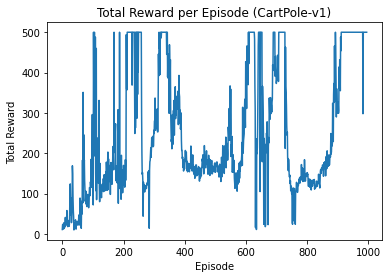

In [18]:
# Plot the total reward per episode graph
cartpole_rewards = pd.read_pickle("./rewards/a2c_cartpole_rewards.pkl")
plt.plot(cartpole_rewards)
plt.title('Total Reward per Episode (CartPole-v1)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [19]:
# evaluate the agent
eval_reward_history = agent.evaluate(num_episodes=10, render=False)

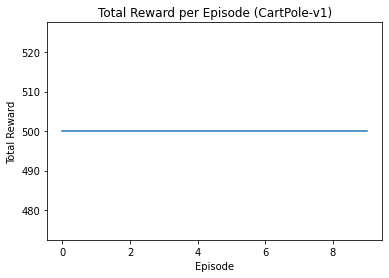

In [20]:
# Plot the total reward per episode graph
plt.plot(eval_reward_history)
plt.title('Total Reward per Episode (CartPole-v1)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Part 2: Solving Complex Environments

### Acrobot Environment

In [5]:
# define the environment
env = gymnasium.make("Acrobot-v1")

In [6]:
# define model
num_actions = env.action_space.n
num_hidden_units = 128
model = ActorCritic(num_actions, num_hidden_units)

2024-04-24 09:58:11.664288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 09:58:12.056500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79093 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:b5:00.0, compute capability: 9.0


In [7]:
# define agent
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=500*500,
    decay_rate=0.99,
    staircase=False)
adam_opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

agent = A2CAgent(env, model, adam_opt, gamma=0.99)

In [8]:
acrobot_rewards = agent.train(num_episodes=10000, max_steps_per_episode=1000, early_stopping=True, reward_threshold=-100)

2024-04-24 09:58:23.988352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-24 09:58:24.418752: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x148db005a650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 09:58:24.418799: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA H100 PCIe, Compute Capability 9.0
2024-04-24 09:58:24.422376: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 09:58:24.533632: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 1, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 2, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 3, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 4, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 5, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 6, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 7, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 8, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 9, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 10, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 11, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 12, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 13, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 14, Reward: -500.00, Steps: 0, Running Mean Reward: -500.00
Episode: 15, Reward: -500.00, Steps: 0, Run

In [9]:
# save the weights of the model
os.makedirs("./weights", exist_ok=True)
agent.save_weights("./weights/a2c_acrobot.weights.h5")

In [10]:
# load the weights of the model
agent.load_weights("./weights/a2c_acrobot.weights.h5")

In [11]:
# save reward history as pickle file
os.makedirs("./rewards", exist_ok=True)
with open("./rewards/a2c_acrobot_rewards.pkl", "wb") as f:
    pickle.dump(acrobot_rewards, f)

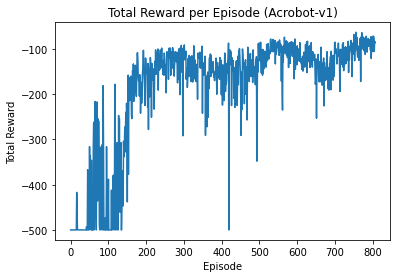

In [12]:
# Plot the total reward per episode graph
acrobot_rewards = pd.read_pickle("./rewards/a2c_acrobot_rewards.pkl")
plt.plot(acrobot_rewards)
plt.title('Total Reward per Episode (Acrobot-v1)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [13]:
# evaluate the agent
eval_reward_history = agent.evaluate(num_episodes=10, render=False)

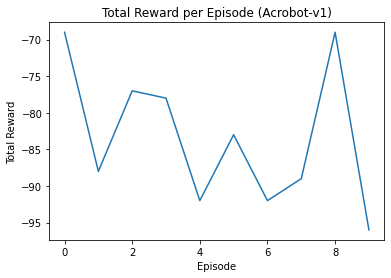

In [14]:
# Plot the total reward per episode graph
plt.plot(eval_reward_history)
plt.title('Total Reward per Episode (Acrobot-v1)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

### Atari Pong Environment

In [5]:
@tf.function
def preprocess_img(x: tf.Tensor):
    """
    Preprocess 210x160x3 uint8 frame into 5600 (80x70) 2D (5600x1) float32 tensorflow vector.
    """
    x = x[35:195, 10:150][::2, ::2, 0]
    x = tf.where((x == 144) | (x == 109), 0, x)
    x = tf.where(x != 0, 1, x)
    x = tf.cast(tf.reshape(x, (-1, 1)), tf.float32)
    x = tf.squeeze(x)
    return x

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    global agent
    state, reward, done, trunc, _ = agent.env.step(action)
    return (state.astype(np.int32), 
            np.array(reward, np.int32), 
            np.array((done or trunc), np.int32))

def tf_env_step(action: tf.Tensor):
    state, reward, done = tf.numpy_function(
        env_step,
        [action],
        [tf.int32, tf.int32, tf.int32]
    )
    state = preprocess_img(state)
    
    return state, reward, done

def run_episode(
        initial_state: tf.Tensor,  
        model: tf.keras.Model, 
        max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """Runs a single episode to collect training data."""

    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
        
    initial_state = tf.cast(initial_state, tf.int32)
    initial_state = preprocess_img(initial_state)

    initial_state_shape = initial_state.shape
    state = initial_state

    for t in tf.range(max_steps):
        # Convert state into a batched tensor (batch size = 1)
        state = tf.expand_dims(state, 0)
    
        # Run the model and to get action probabilities and critic value
        action_logits_t, value = model(state)
    
        # Sample next action from the action probability distribution
        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)

        # Store critic values
        values = values.write(t, tf.squeeze(value))

        # Store log probability of the action chosen
        action_probs = action_probs.write(t, action_probs_t[0, action])
    
        # Apply action to the environment to get next state and reward
        state, reward, done = tf_env_step(action)
        state.set_shape(initial_state_shape)
    
        # Store reward
        rewards = rewards.write(t, reward)

        if tf.cast(done, tf.bool):
            break

    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()
    
    return action_probs, values, rewards

In [6]:
# define the environment
env = gymnasium.make("ALE/Pong-v5")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [7]:
# define model
num_actions = env.action_space.n
num_hidden_units = 512
model = ActorCritic(num_actions, num_hidden_units)

2024-04-25 13:16:50.261130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 13:16:50.641194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79093 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:b5:00.0, compute capability: 9.0


In [8]:
# define agent
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000000,
    decay_rate=0.99,
    staircase=False)
adam_opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

agent = A2CAgent(env, model, adam_opt, gamma=0.99)

In [9]:
pong_rewards = agent.train(num_episodes=20000, max_steps_per_episode=10000, early_stopping=True, reward_threshold=16)

2024-04-25 13:17:05.987013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-25 13:17:07.094654: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x15393400d020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-25 13:17:07.094709: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA H100 PCIe, Compute Capability 9.0
2024-04-25 13:17:07.099044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-25 13:17:07.209145: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 1, Reward: -21.00, Running Mean Reward: -21.00
Episode: 2, Reward: -19.00, Running Mean Reward: -20.00
Episode: 3, Reward: -21.00, Running Mean Reward: -20.33
Episode: 4, Reward: -21.00, Running Mean Reward: -20.50
Episode: 5, Reward: -20.00, Running Mean Reward: -20.40
Episode: 6, Reward: -21.00, Running Mean Reward: -20.50
Episode: 7, Reward: -21.00, Running Mean Reward: -20.57
Episode: 8, Reward: -21.00, Running Mean Reward: -20.62
Episode: 9, Reward: -21.00, Running Mean Reward: -20.67
Episode: 10, Reward: -21.00, Running Mean Reward: -20.70
Episode: 11, Reward: -21.00, Running Mean Reward: -20.73
Episode: 12, Reward: -21.00, Running Mean Reward: -20.75
Episode: 13, Reward: -21.00, Running Mean Reward: -20.77
Episode: 14, Reward: -21.00, Running Mean Reward: -20.79
Episode: 15, Reward: -21.00, Running Mean Reward: -20.80
Episode: 16, Reward: -21.00, Running Mean Reward: -20.81
Episode: 17, Reward: -20.00, Running Mean Reward: -20.76
Episode: 18, Reward: -21.00, Running Mea

In [10]:
# save the weights of the model
os.makedirs("./weights", exist_ok=True)
agent.save_weights("./weights/a2c_pong.weights.h5")

In [11]:
# load the weights of the model
agent.load_weights("./weights/a2c_pong.weights.h5")

In [12]:
# save reward history as pickle file
os.makedirs("./rewards", exist_ok=True)
with open("./rewards/a2c_pong_rewards.pkl", "wb") as f:
    pickle.dump(pong_rewards, f)

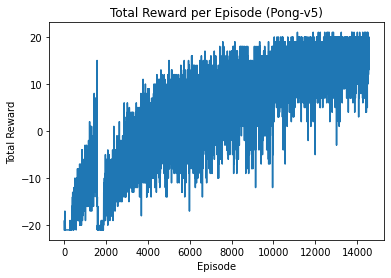

In [13]:
# Plot the total reward per episode graph
pong_rewards = pd.read_pickle("./rewards/a2c_pong_rewards.pkl")
plt.plot(pong_rewards)
plt.title('Total Reward per Episode (Pong-v5)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [14]:
# evaluate the agent
eval_reward_history = agent.evaluate(num_episodes=10, preprocess=True, render=False)

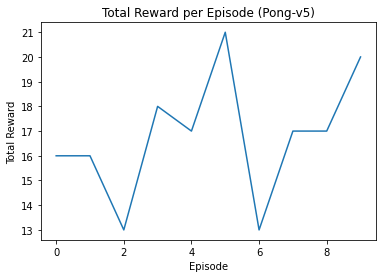

In [15]:
# plot the total reward per episode graph
plt.plot(eval_reward_history)
plt.title('Total Reward per Episode (Pong-v5)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()